<a href="https://colab.research.google.com/github/duypham01/PDE_Poisson/blob/master/PDE_Poisson(pytorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.autograd import grad
import random
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import itertools
import time


In [2]:
class PDEInputLayer(nn.Module):
    def __init__(self, dim, units):
        super(PDEInputLayer, self).__init__()
        self.W = nn.Parameter(torch.Tensor(units, dim))
        self.b = nn.Parameter(torch.Tensor(units, 1))
    def init_weights(self):
        for p in self.parameters():
            nn.init.xavier_uniform_(p.data)
    def forward(self, x):
        return torch.tanh(torch.mm(self.W, x) + self.b)

In [3]:
class PDELayer(nn.Module):
    def __init__(self, dim, units):
        super(PDELayer, self).__init__()
        self.units = units
        self.Uz = torch.nn.Parameter(torch.Tensor(units, dim))
        self.Wz = torch.nn.Parameter(torch.Tensor(units, units))
        self.bz = torch.nn.Parameter(torch.Tensor(units, 1))

        self.Ug = torch.nn.Parameter(torch.Tensor(units, dim))
        self.Wg = torch.nn.Parameter(torch.Tensor(units, units))
        self.bg = torch.nn.Parameter(torch.Tensor(units, 1))

        self.Ur = torch.nn.Parameter(torch.Tensor(units, dim))
        self.Wr = torch.nn.Parameter(torch.Tensor(units, units))
        self.br = torch.nn.Parameter(torch.Tensor(units, 1))

        self.Uh = torch.nn.Parameter(torch.Tensor(units, dim))
        self.Wh = torch.nn.Parameter(torch.Tensor(units, units))
        self.bh = torch.nn.Parameter(torch.Tensor(units, 1))

    def init_weights(self):
        for p in self.parameters():
            nn.init.xavier_uniform_(p.data)
    def forward(self, input):
        S = input[0]
        x = input[1]
        Ones = torch.ones(self.units, 1)
        Z = torch.tanh(torch.mm(self.Uz, x) + torch.mm(self.Wz, S) + self.bz)
        G = torch.tanh(torch.mm(self.Ug, x) + torch.mm(self.Wg, S) + self.bg)
        R = torch.tanh(torch.mm(self.Ur, x) + torch.mm(self.Wr, S) + self.br)
        H = torch.tanh(torch.mm(self.Uh, x) + torch.mm(self.Wh, S * R) + self.bh)

        return (Ones - G) * H + S * Z

In [4]:
class PDEOutputLayer(nn.Module):
    def __init__(self, dim, units):
        super(PDEOutputLayer, self).__init__()
        self.W = nn.Parameter(torch.Tensor(1, units))
        self.b = nn.Parameter(torch.Tensor(1, 1))
    def init_weights(self):
        for p in self.parameters():
            nn.init.xavier_uniform_(p.data)
    def forward(self, x):
        return torch.mm(self.W, x) + self.b

In [5]:
class PDENet(nn.Module):
    def __init__(self, dim, units = 10):
        super().__init__()
        self.dim = dim
        self.units = units
        self.L1 = PDEInputLayer(dim, units)
        self.L2 = PDELayer(dim, units)
        self.L3 = PDELayer(dim, units)
        self.L4 = PDEOutputLayer(dim, units)
    def init_weights(self):
        for p in self.parameters():
            nn.init.xavier_uniform_(p.data)
    def forward(self, x):
        S = self.L1(x)
        S = self.L2([S, x])
        S = self.L3([S, x])
        S = self.L4(S)
        return S

In [6]:
def laplacian(f, input_vector):
    gradient = grad(f, input_vector, create_graph=True)[0]
    ux = gradient.take(torch.tensor([0]))
    uxx = grad(ux, input_vector, create_graph=True)[0].take(torch.tensor([0]))
    uy = gradient.take(torch.tensor([1]))
    uyy = grad(uy, input_vector, create_graph=True)[0].take(torch.tensor([1]))
    return uxx + uyy


def boundary_condition(input):
    return 0


# -laplace(u) = f
def right_hand_side(input):
    return 2*(math.pi)**2*math.sin(math.pi*input.take(torch.tensor([0])))*math.sin(math.pi*input.take(torch.tensor([1])))


def exact_solution(input):
    return math.sin(math.pi*input.take(torch.tensor([0])))*math.sin(math.pi*input.take(torch.tensor([1])))


def random_data_points(batch_size):
    Omegapoints = []
    boundary_points = []
    for i in range(batch_size):
        Omegapoints.append([random.uniform(0, 1), random.uniform(0, 1)])

    for i in range(batch_size):
        random_point = [random.uniform(0, 1), random.uniform(0, 1)]
        random_index = random.randint(0,1)
        random_value = random.randint(0,1)
        random_point[random_index] = random_value
        boundary_points.append(random_point)
    return Omegapoints, boundary_points


def batch_loss(net, datapoints):
    G1 = G2 = 0
    Omegapoints, boundary_points = datapoints
    for Omegapoint in Omegapoints:
        Omegapoint_input = Variable(torch.Tensor(Omegapoint).resize_(2, 1), requires_grad=True)
        Omegapoint_output = net(Omegapoint_input)
        G1 += (- laplacian(Omegapoint_output, Omegapoint_input) - right_hand_side(Omegapoint_input)) ** 2

    for boundary_point in boundary_points:
        boundary_point_input = Variable(torch.Tensor(boundary_point).resize_(2, 1), requires_grad=True)
        boundary_point_output = net(boundary_point_input)
        G2 += (boundary_point_output - boundary_condition(boundary_point_input))**2

    G1 = G1 / len(Omegapoints)
    G2 = G2 / len(boundary_points)
    return G1 + G2


def plot_estimation_and_exact_solution(file_name):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(0, 3, 0.05)
    X, Y = np.meshgrid(x, y)
    condition = X ** 2 + Y ** 2 <= 6
    zs = np.array([net(torch.tensor([x, y]).resize_(2,1)).item() for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)

    zs = np.array([exact_solution_scalar_value(x, y) for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z1 = zs.reshape(X.shape)

    ax.plot_surface(X, Y, Z, color='red')
    ax.plot_surface(X, Y, Z1, color='blue')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    # plt.show()
    plt.savefig(file_name)
    plt.close("all")


def random_points_test():
    points = []
    for i in range(2000):
        points.append([random.uniform(0, 1), random.uniform(0, 1)])
    return points

Iteration number: 1
Batch loss: tensor([[92.1592102051]], grad_fn=<AddBackward0>)
This iteration took 11.327248096466064 seconds
Total training time elapsed 0.18886600732803344 minutes
L2error = tensor([[0.0163429510]], grad_fn=<DivBackward0>)
Finished iteration number 1, saving model
Iteration number: 2
Batch loss: tensor([[60.7864723206]], grad_fn=<AddBackward0>)
This iteration took 11.606203556060791 seconds
Total training time elapsed 0.39913598299026487 minutes
L2error = tensor([[0.0217844564]], grad_fn=<DivBackward0>)
Finished iteration number 2, saving model
Iteration number: 3
Batch loss: tensor([[38.3665428162]], grad_fn=<AddBackward0>)
This iteration took 11.047905921936035 seconds
Total training time elapsed 0.6007983843485515 minutes
L2error = tensor([[0.0263322666]], grad_fn=<DivBackward0>)
Finished iteration number 3, saving model
Iteration number: 4
Batch loss: tensor([[24.5950584412]], grad_fn=<AddBackward0>)
This iteration took 10.8490309715271 seconds
Total training t

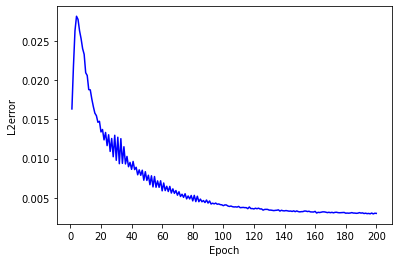

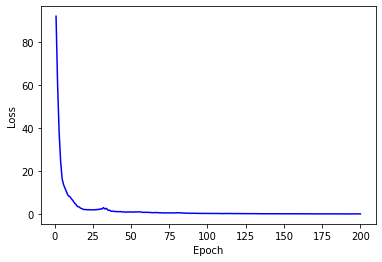

In [7]:
net = PDENet(2, 10)
net.init_weights()

# plot_estimation_and_exact_solution('./result/testnoBatch/Initial.png')
l2_errors = []
losses = []

# net = torch.load('./model3')
torch.set_printoptions(precision=10)
learning_rate = 0.001
iterations_count = 0
start_training = time.time()
for i in range(200):
    print('Iteration number: ' + str(i + 1))
    sample = random_data_points(1000)  # sample space time point
    start_ite = time.time()
    net.zero_grad()
    square_error = batch_loss(net, sample)  # calculate square error loss
    square_error.backward()  # calculate gradient of square loss w.r.t the parameters
    print('Batch loss: ' + str(square_error))
    for param in net.parameters():
        param.data -= learning_rate * param.grad.data
    losses.append(square_error.item())
    end_ite = time.time()
    ite_time = end_ite - start_ite
    total_time = end_ite - start_training
    print('This iteration took ' + str(ite_time) + ' seconds')
    print('Total training time elapsed ' + str(total_time/60) + ' minutes')
    L2_error = 0
    points, boundary_points = random_data_points(1000)
    for point in points:
        point_input = torch.Tensor(point).resize_(2,1)
        L2_error += (net(point_input) - exact_solution(point_input))**2
    for boundary in boundary_points:
        point_input = torch.Tensor(boundary).resize_(2,1)
        L2_error += (net(point_input) - exact_solution(point_input))**2
    L2_error = torch.sqrt(L2_error)/2000
    l2_errors.append(L2_error.item())

    print('L2error = ' + str(L2_error))
    # print('Loss function = ' + str(square_error))

    print('Finished iteration number ' + str(i + 1) + ', saving model')
    model_path = './result/testnoBatch/model' + str(i+1) + 'th_ite'
   # net.save(model_path)
    # fig_path = './result/testnoBatch/' + str(i+1) + 'th_ite.png'
    # plot_estimation_and_exact_solution(fig_path)

print('Plotting and saving convergence history')
epochs = [i + 1 for i in range(200)]
plt.xticks(np.arange(0, 201, 20))

plt.figure(0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epochs, losses, color = 'blue')
# plt.savefig('./result/testnoBatch/loss.png')

# with open('./result/testnoBatch/batchloss.txt', 'w+') as f:
#     for loss in losses:
#         f.write(str(loss) + '\n')

plt.figure(1)
plt.xlabel('Epoch')
plt.ylabel('L2error')

plt.plot(epochs, l2_errors, color = 'blue')
# plt.savefig('./result/testnoBatch/l2error.png')
# with open('./result/testnoBatch/L2error.txt', 'w+') as f:
#     for l2_error in l2_errors:
#         f.write(str(l2_error) + '\n')


In [8]:
torch.save(net.state_dict(), 'PDEnet_parameters.pt')

In [10]:
model = PDENet(2, 10)
model.load_state_dict(torch.load('PDEnet_parameters.pt'))

<All keys matched successfully>

In [11]:
L2_error = 0
points, boundary_points = random_data_points(1000)
for point in points:
    point_input = torch.Tensor(point).resize_(2,1)
    L2_error += (model(point_input) - exact_solution(point_input))**2
for boundary in boundary_points:
    point_input = torch.Tensor(boundary).resize_(2,1)
    L2_error += (net(point_input) - exact_solution(point_input))**2
L2_error = torch.sqrt(L2_error)/2000
l2_errors.append(L2_error.item())

print('L2error = ' + str(L2_error))

L2error = tensor([[0.0028988209]], grad_fn=<DivBackward0>)
